In [1]:
from google.cloud import bigquery
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
import requests
import json
# import tensorflow as tf
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# nvcc --version  ###CUDA version

import pathlib
import shutil
from numpy.random import seed
seed(2)
from tensorflow.random import set_seed
set_seed(2)
from math import sqrt
import os

random_state = 42
# import mlflow
# exp_id = 'weather_dataset'
# mlflow.set_experiment(exp_id)
# mlflow.set_tracking_uri('file:///C:/Users/gabri/VSCode%20Projects/Weather%20Prediction/mlruns')
# mlflow.autolog()
# mlflow.log_param('random_state', random_state)
# export MLFLOW_TRACKING_URI=http://192.168.0.1:5000


In [2]:
# specify project dataset and table
client = bigquery.Client()
project_id = os.environ.get('GOOGLE_CLOUD_PROJECT')
dataset_id = 'weather_api'
table_id = 'union_weather_api_training'

In [3]:
# specify date range
# training_start = '2021-08-01 00:00:00'  
# training_end = '2022-08-12 00:01:00'  

training_start = '2015-01-01 00:00:00'  
training_end = '2021-02-01 00:00:00'  

hours_difference = (datetime.datetime.strptime(training_end, '%Y-%m-%d %H:%M:%S') - datetime.datetime.strptime(training_start, '%Y-%m-%d %H:%M:%S')).total_seconds() / 3600
print(f'The expected number of hours between the two dates is: {round(hours_difference)} hours')

date_obj_start = datetime.datetime.strptime(training_start, '%Y-%m-%d %H:%M:%S')  # Include '%H:%M:%S'
date_obj_end = datetime.datetime.strptime(training_end, '%Y-%m-%d %H:%M:%S')  # Include '%H:%M:%S'
unix_start = int(date_obj_start.timestamp())
unix_end = int(date_obj_end.timestamp())

# specify locations
location_1 = 'clerkenwell'
location_2 = 'hadley_wood'
print('Locations: ', location_1, location_2)

The expected number of hours between the two dates is: 53352 hours
Locations:  clerkenwell hadley_wood


In [4]:
query = f"""
SELECT 
    dt,
    city_name,
    temp_c, 
    pressure,
    humidity
FROM `{project_id}.{dataset_id}.{table_id}`
where dt > {unix_start} and dt < {unix_end}
order by dt
"""
query_job = client.query(query)
df = query_job.to_dataframe()
print(f'Gets data from {training_start} to {training_end} from {location_1} and {location_2} and merges the two tables')

Gets data from 2015-01-01 00:00:00 to 2021-02-01 00:00:00 from clerkenwell and hadley_wood and merges the two tables


In [5]:
pivot_table = df.pivot(index='dt', columns='city_name', values=['temp_c', 'pressure', 'humidity']).reset_index()
pivot_table.columns.name = None  # Remove the name from the columns
pivot_table.columns = ['dt', 'temp_clerkenwell', 'temp_hadley_wood', 'pressure_clerkenwell', 'pressure_hadley_wood', 'humidity_clerkenwell', 'humidity_hadley_wood']
# features = ['temp_clerkenwell', 'temp_hadley_wood', 'pressure_clerkenwell', 'pressure_hadley_wood', 'humidity_clerkenwell', 'humidity_hadley_wood']
features = ['temp_clerkenwell', 'pressure_clerkenwell', 'humidity_clerkenwell']
pivot_table.head(2)

dt  temp_clerkenwell  temp_hadley_wood  pressure_clerkenwell  \
0  1420074000               6.0               5.0                1032.0   
1  1420077600               6.0               6.0                1031.0   

   pressure_hadley_wood  humidity_clerkenwell  humidity_hadley_wood  
0                1032.0                  81.0                  92.0  
1                1032.0                  81.0                  92.0

In [6]:
missing_timestamps = np.diff(pivot_table['dt'])
result_indices = np.where(missing_timestamps != 3600)[0]
result_values = missing_timestamps[result_indices]
print("Indices with non-3600 differences:", result_indices)
print("Values of differences at those indices:", result_values)

Indices with non-3600 differences: []
Values of differences at those indices: []


In [7]:
# create timestamps and data
timestamps_array = pivot_table['dt'].to_numpy()
data_array = pivot_table[features].to_numpy()

In [8]:
start_date = datetime.datetime.utcfromtimestamp(timestamps_array[0])
end_date = datetime.datetime.utcfromtimestamp(timestamps_array[-1]),

context_hours = 24*3
prediction_length = 24
dataset_length = len(data_array)
eliminated_timesteps = context_hours

print(f'Dataset starts on {start_date}')
print(f'Dataset ends on {end_date[0]}')
print(f'Original length of dataset: {dataset_length} hours')


print(f'Length of context: {context_hours} hours')
print(f'Number of hours to predict : {prediction_length} hours')
print(f'Given temperature from the last {context_hours} hours, we want to predict temperature over the next {prediction_length} hours')
print(f'In order to create windows, we lose {eliminated_timesteps} hours to create the first window')

new_dataset_length = dataset_length - eliminated_timesteps
window_count = new_dataset_length
print(f'Number of datapoints for training, validation and testing: {new_dataset_length} hours')

Dataset starts on 2015-01-01 01:00:00
Dataset ends on 2021-01-31 23:00:00
Original length of dataset: 53351 hours
Length of context: 72 hours
Number of hours to predict : 24 hours
Given temperature from the last 72 hours, we want to predict temperature over the next 24 hours
In order to create windows, we lose 72 hours to create the first window
Number of datapoints for training, validation and testing: 53279 hours


In [9]:
# 7 Define train, val and test ratios
print(f'Initial timesteps: ', dataset_length)
print(f'Sacrificial datapoints: 0 - {eliminated_timesteps}')

final_length = dataset_length-eliminated_timesteps
print(f'Final length: {final_length}')

window_start = 0
train = 0.6
val = 0.2
test = 0.2
print(f'Train, validation, test split: {train} - {val} - {test}')


train_start = eliminated_timesteps
val_start = int((final_length)*train) + train_start
test_start = int((final_length)*(val)) + val_start 
test_end = final_length
train_batch_size = val_start - train_start
val_batch_size = test_start - val_start
test_batch_size = dataset_length - test_start
# test_end = dataset_length - eliminated_timesteps
print(f'Train: {train_start}-{val_start}. Train batch size: {train_batch_size}')
print(f'Validate: {val_start}-{test_start}. Validation batch size: {val_batch_size}')
print(f'Test: {test_start}-{dataset_length}. Test batch size {test_batch_size}')



Initial timesteps:  53351
Sacrificial datapoints: 0 - 72
Final length: 53279
Train, validation, test split: 0.6 - 0.2 - 0.2
Train: 72-32039. Train batch size: 31967
Validate: 32039-42694. Validation batch size: 10655
Test: 42694-53351. Test batch size 10657


In [10]:
import warnings
warnings.filterwarnings("ignore", message="The behavior of DatetimeProperties.to_pydatetime is deprecated*")

fig = go.Figure()
window_trace = px.scatter(x=pivot_table['dt'].iloc[window_start:train_start], y=pivot_table['temp_clerkenwell'].iloc[window_start:train_start]).data[0]
window_trace.update(line=dict(color='purple'), marker=dict(color='purple'), name=f'Eliminated indices: {window_start}-{train_start}. Count:{eliminated_timesteps}', showlegend=True)
fig.add_trace(window_trace)

# Plot the training data
train_trace = px.scatter(x=pivot_table['dt'].iloc[train_start:val_start], y=pivot_table['temp_clerkenwell'][train_start:val_start]).data[0]
train_trace.update(line=dict(color='blue'), marker=dict(color='blue'), name=f'Train Data: {train_start}-{val_start}. Count:{train_batch_size}', showlegend=True)

# Plot the validation data
val_trace = px.scatter(x=pivot_table['dt'].iloc[val_start:test_start], y=pivot_table['temp_clerkenwell'][val_start:test_start]).data[0]
val_trace.update(line=dict(color='green'), marker=dict(color='green'), name=f'Validation Data: {val_start}-{test_start}. Count:{val_batch_size}', showlegend=True)

# Plot the test data
test_trace = px.scatter(x=pivot_table['dt'].iloc[test_start: dataset_length], y=pivot_table['temp_clerkenwell'][test_start: dataset_length]).data[0]
test_trace.update(line=dict(color='red'), marker=dict(color='red'), name=f'Test Data: {test_start}-{dataset_length}. Count:{test_batch_size}', showlegend=True)

# # Plot all data
all_trace = px.scatter(x=pivot_table['dt'], y=pivot_table['temp_clerkenwell'].to_list()).data[0]
all_trace.update(line=dict(color='yellow'), marker=dict(color='yellow'), name=f'All Data', showlegend=True, mode='lines')

fig.update_layout(showlegend=True)
fig.add_trace(train_trace)
fig.add_trace(val_trace)
fig.add_trace(test_trace)
fig.add_trace(all_trace)
fig.show()

In [11]:
# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pivot_table[features].iloc[train_start:val_start])
df_scaled = pd.DataFrame(scaler.transform(pivot_table[features]))
df_scaled.columns = pivot_table[features].columns
print(f'We calculate the mean and std of the training data and use this to normalise the entire dataframe')
print(pivot_table.head(1))
print(df_scaled.head(1))

We calculate the mean and std of the training data and use this to normalise the entire dataframe
           dt  temp_clerkenwell  temp_hadley_wood  pressure_clerkenwell  \
0  1420074000               6.0               5.0                1032.0   

   pressure_hadley_wood  humidity_clerkenwell  humidity_hadley_wood  
0                1032.0                  81.0                  92.0  
   temp_clerkenwell  pressure_clerkenwell  humidity_clerkenwell
0         -1.015379              1.604285              0.577168


In [12]:
total_length = pivot_table.shape[0]
data = df_scaled[features].to_numpy()
X = []
y = []

for i in range(total_length - context_hours):
    X.append(data[i:i + context_hours])
    y.append(data[i + context_hours:i + context_hours + 1]) 

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((53279, 72, 3), (53279, 1, 3))

In [13]:
# train test split
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_batch_size, shuffle=False)
print(f'X_train_val shape: {X_train_val.shape}')
print(f'y_train_val shape: {y_train_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train_val shape: (42622, 72, 3)
y_train_val shape: (42622, 1, 3)
X_test shape: (10657, 72, 3)
y_test shape: (10657, 1, 3)


In [14]:
from tensorflow import keras
from keras.layers import Dense, Dropout, Embedding, GRU, Bidirectional, InputLayer, LSTM

feature_count = len(features)
print('Number of features: ', feature_count)
print('Context hours: ', context_hours)
model = keras.Sequential()

model.add(InputLayer((context_hours, feature_count)))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dropout(0.1))
model.add(Dense(feature_count, activation='linear'))
model.summary()


Number of features:  3
Context hours:  72
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 64)                9216      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 9411 (36.76 KB)
Trainable params: 9411 (36.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


42622/42622 [==============================] - 523s 12ms/step - loss: 0.0622 - root_mean_squared_error: 0.2494


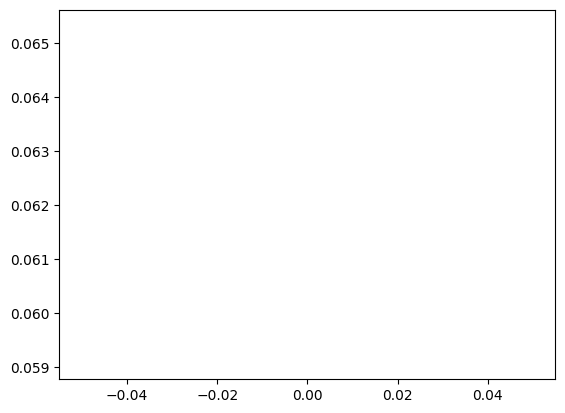

In [15]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
history = model.fit(X_train_val, y_train_val, epochs=1, batch_size=1, verbose=True)
plt.plot(history.history['loss'])

In [22]:
# reshape outputs and inverse scale
scaler.inverse_transform(y_test.reshape(len(y_test), feature_count))
y_test_inv = scaler.inverse_transform(y_test.reshape(len(y_test), feature_count))

y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)

fig = go.Figure()
pred_trace = px.scatter(x=[datetime.datetime.utcfromtimestamp(i) for i in timestamps_array[test_start:dataset_length]], 
           y=y_pred_inv[:, features.index('temp_clerkenwell')]).data[0]
pred_trace.update(marker=dict(color='red'), name = 'pred', showlegend=True)

true_trace = px.scatter(x=[datetime.datetime.utcfromtimestamp(i) for i in timestamps_array[test_start:dataset_length]], 
           y=y_test_inv[:, features.index('temp_clerkenwell')]).data[0]
true_trace.update(marker=dict(color='green'), name='true', showlegend=True)

# get score 
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_value = round(mean_absolute_error(y_test_inv, y_pred_inv), 2)
rmse_value = round(sqrt(mean_squared_error(y_test_inv, y_pred_inv)), 2)
print(f'MAE: {mae_value}')
print(f'RMSE: {rmse_value}')

# Add MAE and RMSE to the title
fig.update_layout(title=f'Figure with MAE={mae_value} and RMSE={rmse_value}')

fig.add_trace(pred_trace)
fig.add_trace(true_trace)
fig.show()

  1/334 [..............................] - ETA: 17s

334/334 [==============================] - 2s 7ms/step
MAE: 1.2
RMSE: 2.0


In [70]:
start = 0
current_batch = X_test[start:start+1,:,:] #takes first sample, all windows and all features
y_pred_scaled = [] 
prediction_length = 24*2

for i in range(prediction_length):
  current_pred = model.predict(current_batch).flatten()
  y_pred_scaled.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


y_pred_inv = scaler.inverse_transform(np.array(y_pred_scaled))
y_pred_inv_plot = y_pred_inv[:, features.index('temp_clerkenwell')]
y_true_inv_plot = y_test_inv[:, features.index('temp_clerkenwell')][start:prediction_length]


fig = go.Figure()
pred_trace = px.scatter(x=[datetime.datetime.utcfromtimestamp(i) for i in timestamps_array[test_start:test_start+prediction_length]], y=y_pred_inv_plot).data[0]
pred_trace.update(marker=dict(color='red'), name = 'pred', showlegend=True)

true_trace = px.scatter(x=[datetime.datetime.utcfromtimestamp(i) for i in timestamps_array[test_start:test_start+prediction_length]], y=y_true_inv_plot).data[0]
true_trace.update(marker=dict(color='green'), name = 'true', showlegend=True)

from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_value = round(mean_absolute_error(y_true_inv_plot, y_pred_inv_plot), 2)
rmse_value = round(sqrt(mean_squared_error(y_true_inv_plot, y_pred_inv_plot)), 2)
print(f'MAE: {mae_value}')
print(f'RMSE: {rmse_value}')

# Add MAE and RMSE to the title
fig.update_layout(title=f'Figure with MAE={mae_value} and RMSE={rmse_value}')


fig.add_trace(pred_trace)
fig.add_trace(true_trace)
fig.show()

1/1 [==============================] - 0s 21ms/step
MAE: 1.96
RMSE: 2.42


In [71]:
model.save("your_model.h5")  # Save as HDF5 format


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [25]:
# model.save('cf_cl.h5')
# model.save('test_model.keras')
# # loaded_model = tf.keras.models.load_model('heath.h5')
# loaded_model

In [26]:
# import tensorflow as tf
# loaded_model = tf.keras.models.load_model('test_model.keras')

In [21]:
# loaded_model.save('test_model.h5')
